Last run: Aug 8

In [1]:
import os

os.environ["CONDA_DEFAULT_ENV"]

'toi-viz'

### fitting Ks mag, Teff, Fe/H, and parallax

In [1]:
from jaxstar import mistfit
from jax import random
import arviz, corner
import pandas as pd

/ut3/jerome/miniconda3/envs/jaxstar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
mf = mistfit.MistFit()

In [4]:
from urllib.request import urlopen
import pandas as pd
import json

def get_tfop_info(target_name: str) -> dict:
    base_url = "https://exofop.ipac.caltech.edu/tess"
    url = f"{base_url}/target.php?id={target_name.replace(' ','')}&json"
    response = urlopen(url)
    assert response.code == 200, "Failed to get data from ExoFOP-TESS"
    try:
        data_json = json.loads(response.read())
        return data_json
    except Exception as e:
        print(e)
        raise ValueError(f"No TIC data found for {target_name}")


def get_params_from_tfop(tfop_info, name="planet_parameters", idx=None):
    params_dict = tfop_info.get(name)
    if idx is None:
        key = "pdate" if name == "planet_parameters" else "sdate"
        # get the latest parameter based on upload date
        dates = []
        for d in params_dict:
            t = d.get(key)
            dates.append(t)
        df = pd.DataFrame({"date": dates})
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        idx = df["date"].idxmax()
    return params_dict[idx]

In [5]:
target = "TOI-5671"
tfop_info = get_tfop_info(target)
star_params = get_params_from_tfop(tfop_info, name="stellar_parameters")
planet_params = get_params_from_tfop(tfop_info, name="planet_parameters")

In [13]:
mags = tfop_info["magnitudes"]
for i in range(len(mags)):
    print(i,mags[i]['band'])

0 TESS
1 V
2 Gaia
3 u
4 g
5 r
6 i
7 z
8 J
9 H
10 K
11 WISE 3.4 micron
12 WISE 4.6 micron
13 WISE 12 micron
14 WISE 22 micron


In [14]:
mags[1]0

{'band': 'K',
 'value': '12.362',
 'value_e': '0.023',
 'mnotes': 'TIC v8.2',
 'mdate': '2019-04-15',
 'muser': 'TESS project',
 'mgroup': '',
 'mtag': '',
 'mtabname': 'kmag'}

In [16]:
# observed Kmag, Teff, Fe/H, parallax (mas)
kmag_obs, kmag_err = 12.362, 0.023 #TIC v8
teff_obs, teff_err = 3278, 124 #IRD
feh_obs, feh_err = 0.31, 0.33 #IRD
parallax_obs, parallax_err = 6.07, 0.03 #mas

In [17]:
mf.set_data(['kmag', 'teff', 'feh', 'parallax'],\
            [kmag_obs, teff_obs, feh_obs, parallax_obs],\
            [kmag_err, teff_err, feh_err, parallax_err])

In [18]:
# setup HMC
ns = 10_000
mf.setup_hmc(num_warmup=ns, num_samples=ns)

In [19]:
# run
rng_key = random.PRNGKey(0)
mf.run_hmc(rng_key, linear_age=True, flat_age_marginal=False, nodata=False)

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:49<00:00, 183.43it/s, 639 steps of size 1.57e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       age      6.35      0.25      6.29      6.02      6.78      5.20      1.44
  distance      0.16      0.00      0.16      0.16      0.16   1227.18      1.00
       eep    259.08      2.28    257.67    257.00    261.64      3.39      1.84
       feh      0.25      0.00      0.25      0.25      0.25    261.75      1.05

Number of divergences: 0


In [20]:
mcmc = mf.mcmc
samples = mf.samples

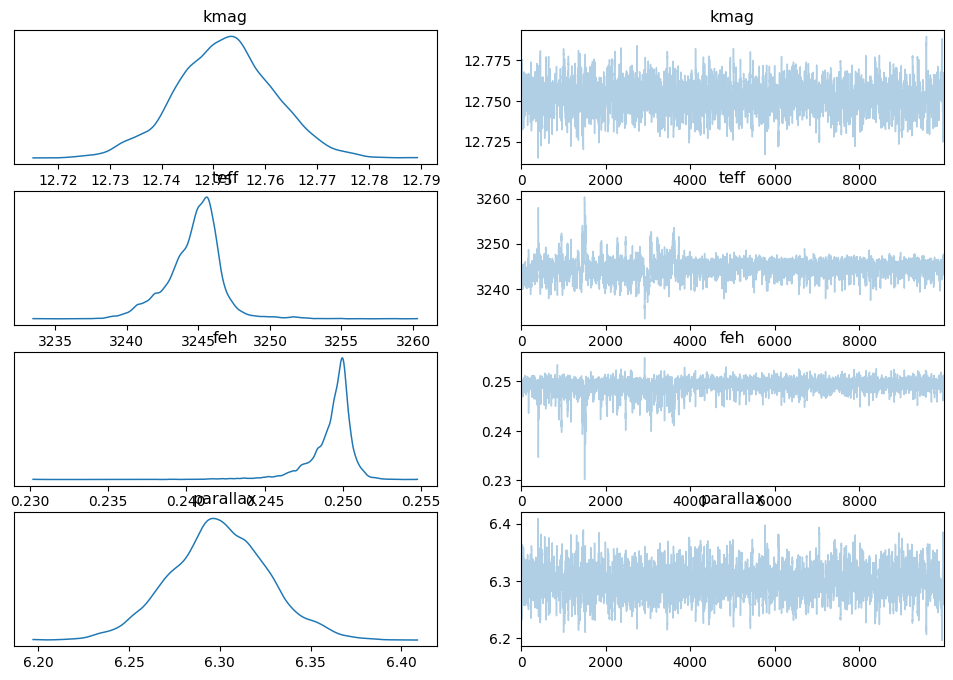

In [21]:
# trace plot
fig = arviz.plot_trace(mcmc, var_names=mf.obskeys)

In [22]:
# keys and observed values for corner plot
outkeys = mf.obskeys + ['mass', 'radius', 'age', 'eep']
obsvals = mf.obsvals + [None] * 4

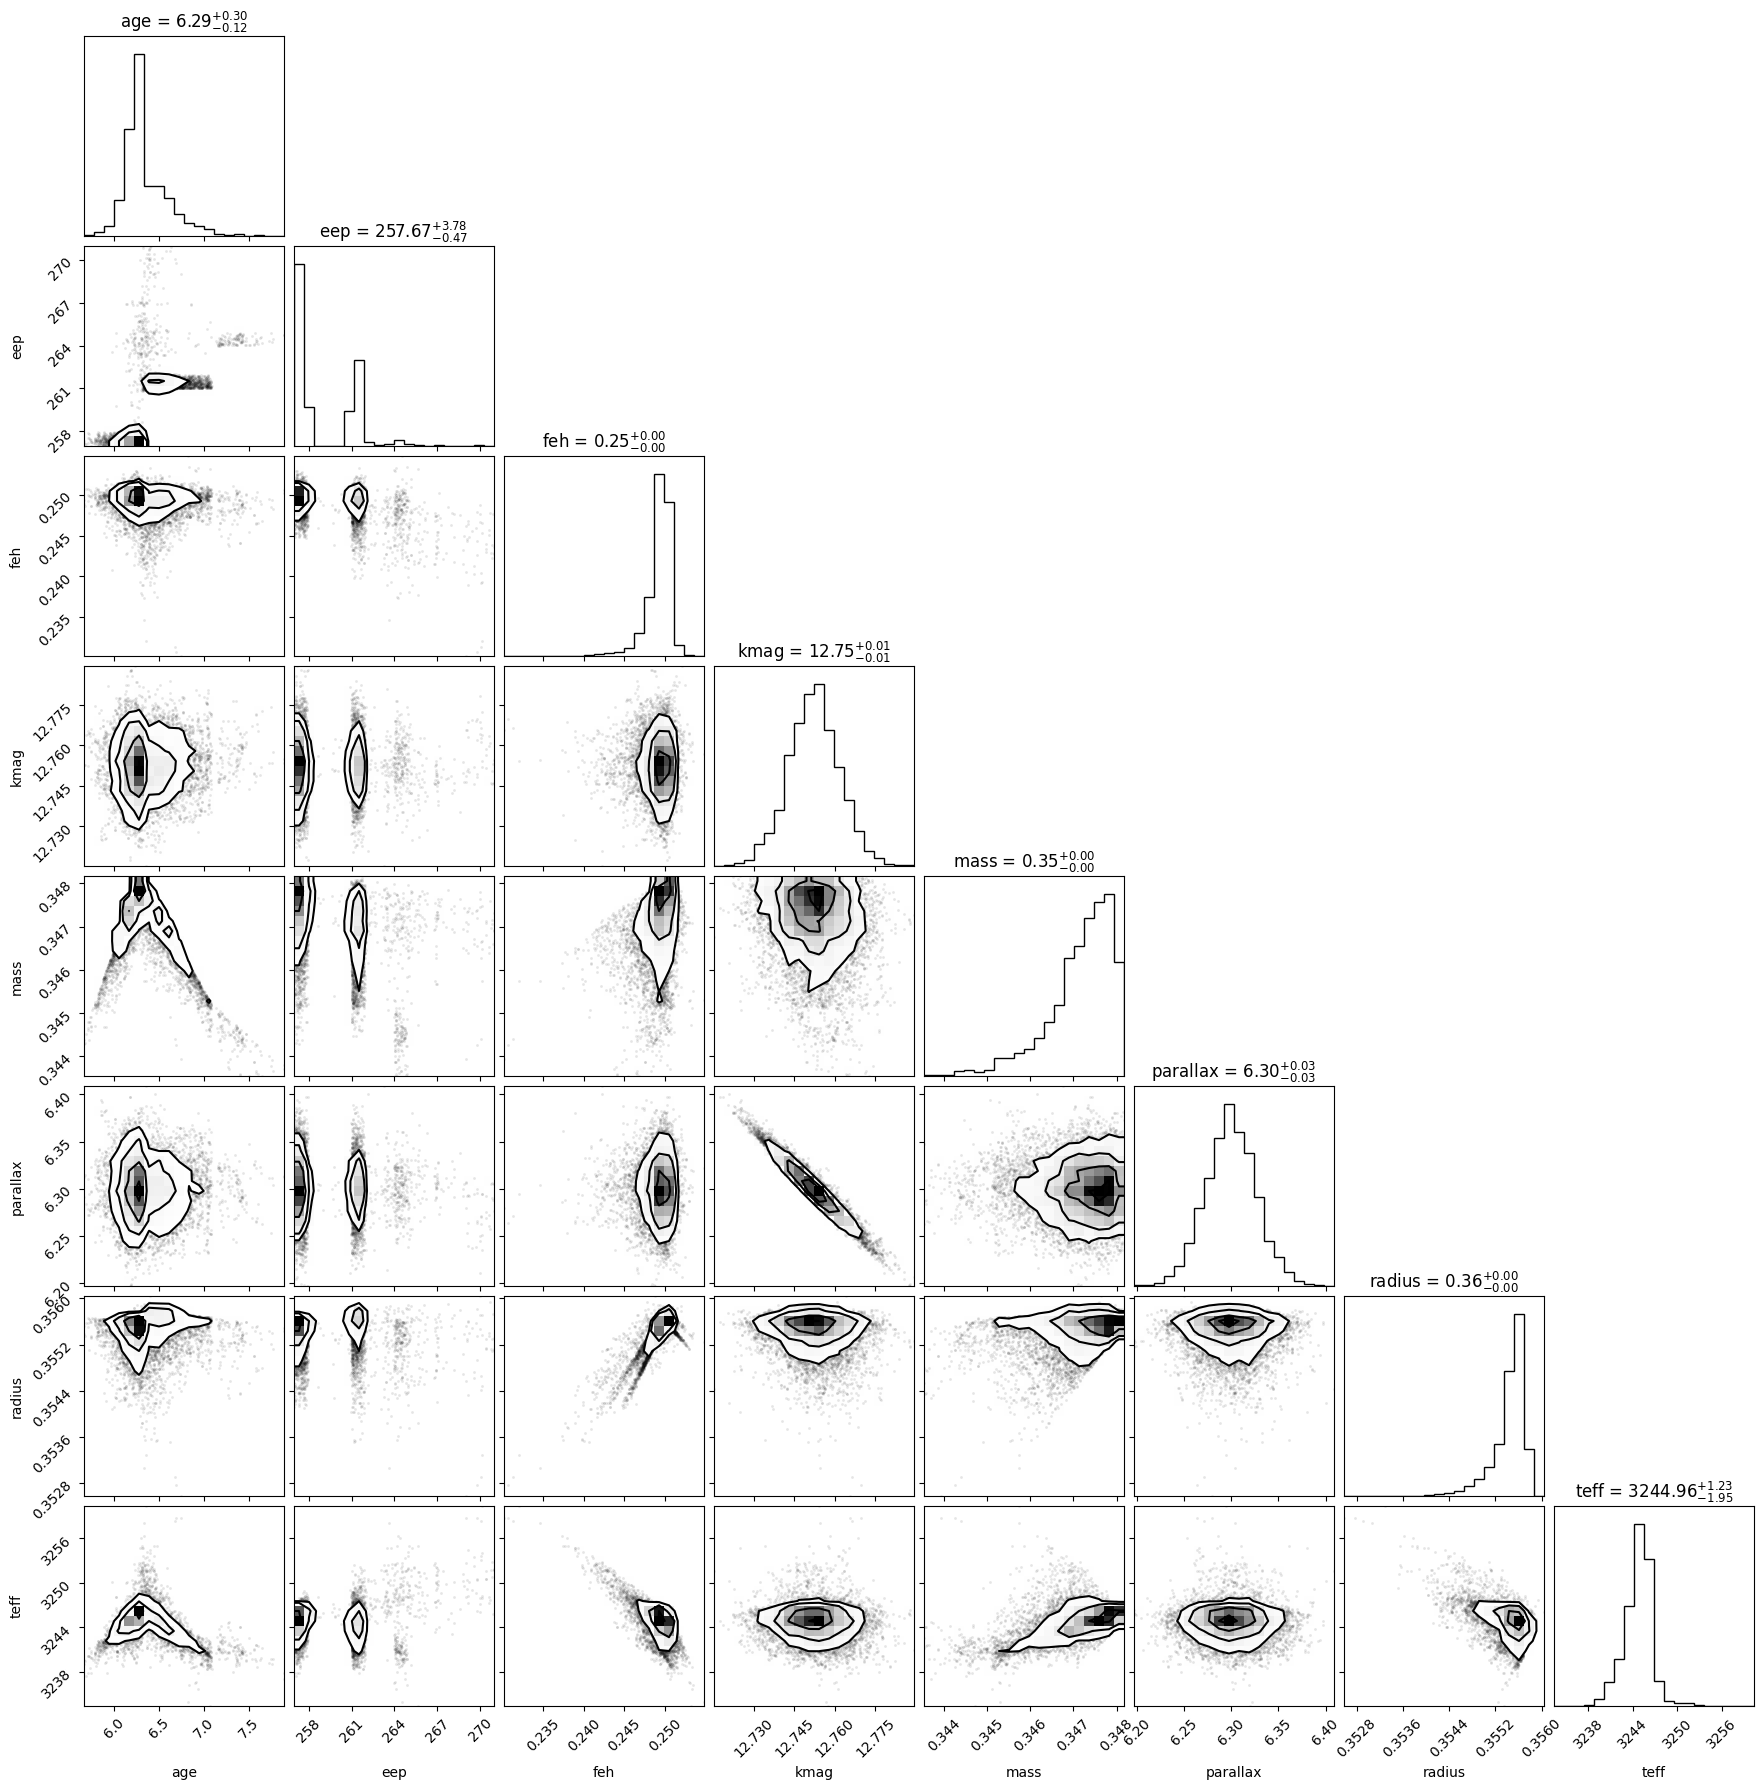

In [27]:
params = arviz.from_dict(dict(zip(outkeys, [samples[k] for k in outkeys])))
fig = corner.corner(params, show_titles="%.2f", truths=obsvals)